# Sphractal Usage Demonstration

This is a demonstration of using `Sphractal` to estimate the fractal dimension of the surface of a 3D object formed from overlapping spheres. 

The directory and file paths in this notebook are set up for the notebook to be run from `sphractal/docs/`. If this is not the case, the path needs to be changed accordingly for the cells to be executed properly. The coordinates in this notebook are visualised using [The Open Visualization Tool (OVITO)](https://www.ovito.org/about/).

In [1]:
%load_ext autoreload
%autoreload 2

## Special Requirement for Point Cloud Surface Representation

`Sphractal` requires an executable compiled from another freely available repository for the functionalities related 
to point clouds surface representation to operate properly. If you haven't done so, follow the steps outlined in [README.md](https://github.com/Jon-Ting/sphractal/blob/main/README.md) to make sure that the executable file is available. 

## Load Example Data

A gold-platinum (Au-Pt) nanoparticle is used here as a test case. Below is a snapshot of the octahedron palladium nanoparticle, and its cross section:

<p align="center">
  <img src="figs/example.png" width="100" height="100"/>
</p>
<p align="center">
  <img src="figs/exampleSliced.png" width="100" height="100"/>
</p>

In [2]:
from sphractal.datasets import getExampleDataPath

xyzFilePath = getExampleDataPath()
print(xyzFilePath)

/mnt/c/Users/ASUS/Documents/PhD/Workstation/PaperDrafts/NP_Frac_Dim/DOCS/sphractal/src/sphractal/data/example.xyz


## Box-Counting Dimension as Estimation of Fractal Dimension

Fractal dimension is a rational statistical index of detail complexity in a pattern. The concept is derived from a mathematical relationship between scaling and dimension: 

$$N = \epsilon ^ {-D}$$

where $N$ is the number of measurement units, $\epsilon$ is the scaling factor, $D$ is the fractal dimension.

<p align="center">
  <img src="figs/Dimension_Concept.png" width="500" height="250"/>
</p>


The box-counting (Minkowski-Bouligand) dimension is commonly calculated as an estimation of the fractal dimension of a given (fractal-like) object (set $S$ in Euclidean space $\mathbb{R}^n$). 

It is derived from:

$$D_{box}(S) = { \text{lim}_{\epsilon \to 0} { { \text{log}( N(\epsilon) ) } \over { \text{log}( {1 \over \epsilon} ) } } }$$

where $N(\epsilon)$ is the number of boxes with side length $\epsilon$ needed to cover set $S$.

## Run Box-Counting Algorithm on an Object

The minimum requirement of input argument to run the box-counting algorithm is simply the path to the xyz file containing the Cartesian coordinates of the object of interest (composed of spherical entities). 

Here we leave most of the optional arguments as default values, but an input argument that you might want to modify if you have not set up the environment variable `FASTBC_EXE` is `exePath`, which is the path to the executable file to run the box-counting algorithms implemented by Ruiz de Miras.

We will also turn on the plot display and increase the verbosity to see a little of what's happening under the hood.


example
  Approximating the surface with 300 point clouds for each atom...
    33204 surface points -> 33204 voxels, # grids: 1024


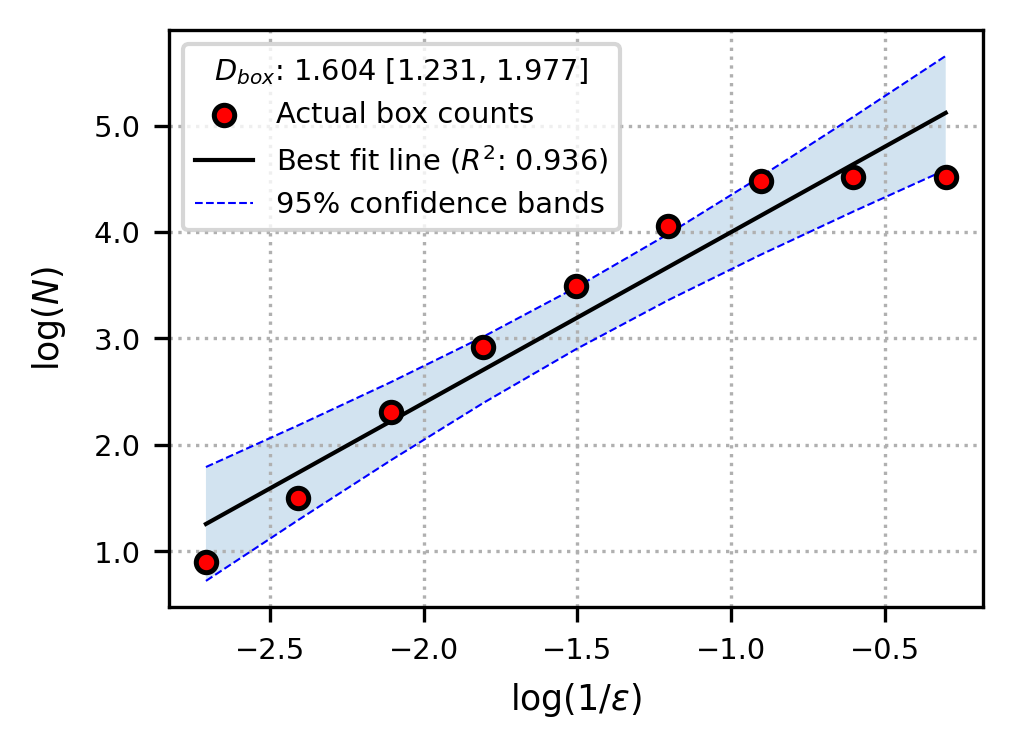

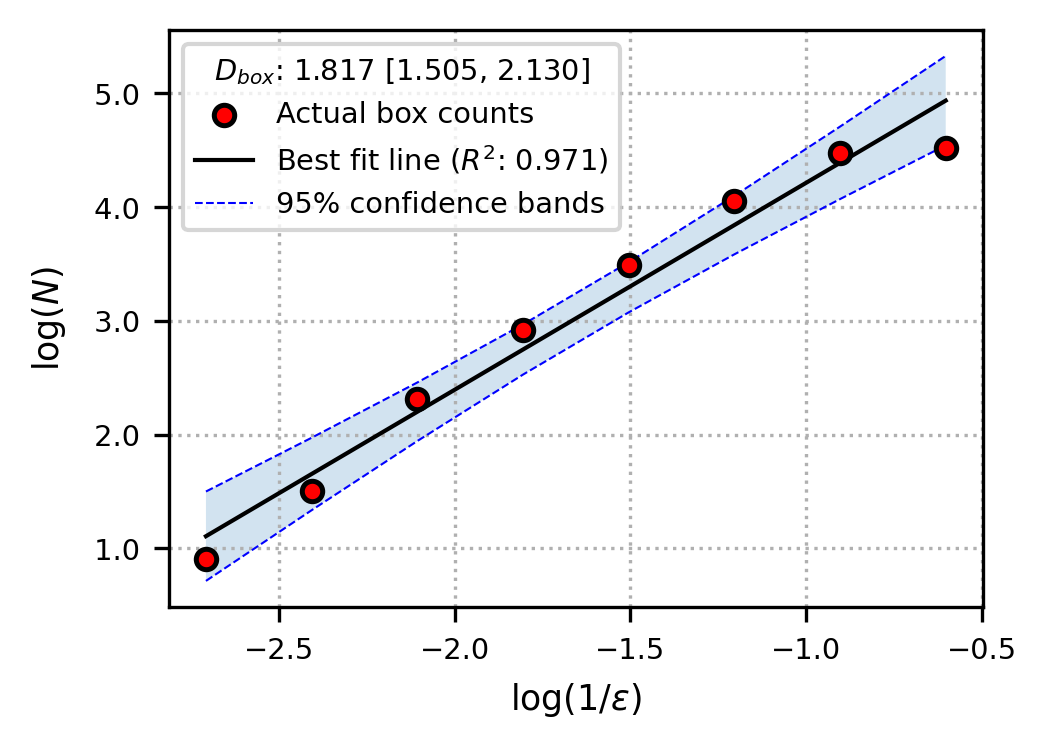

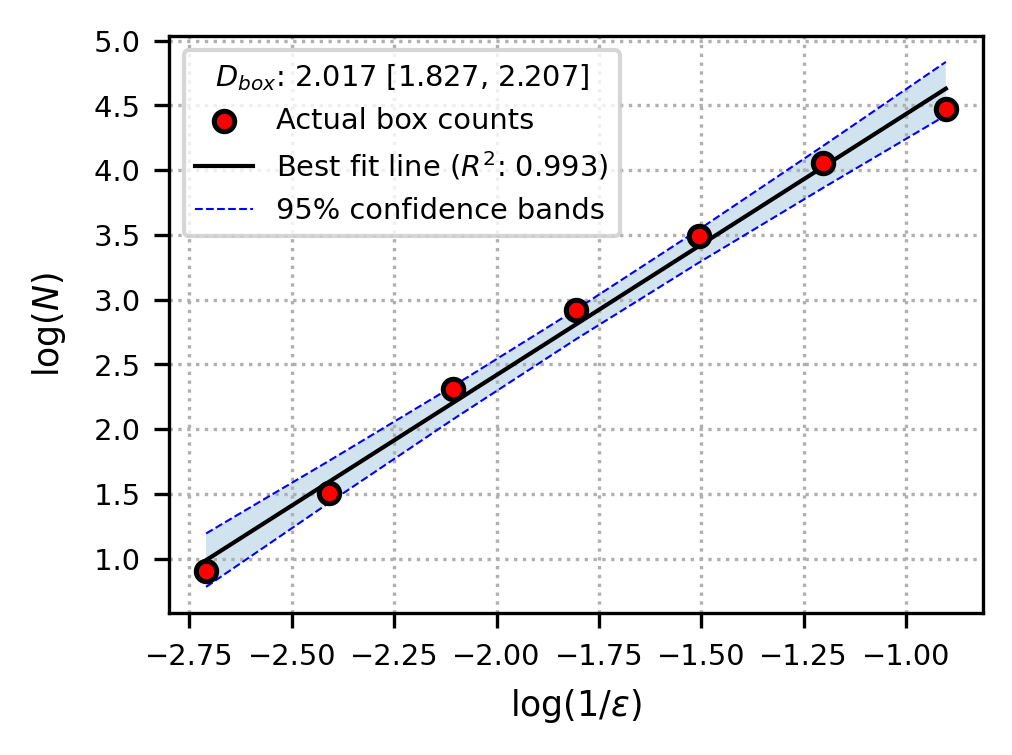

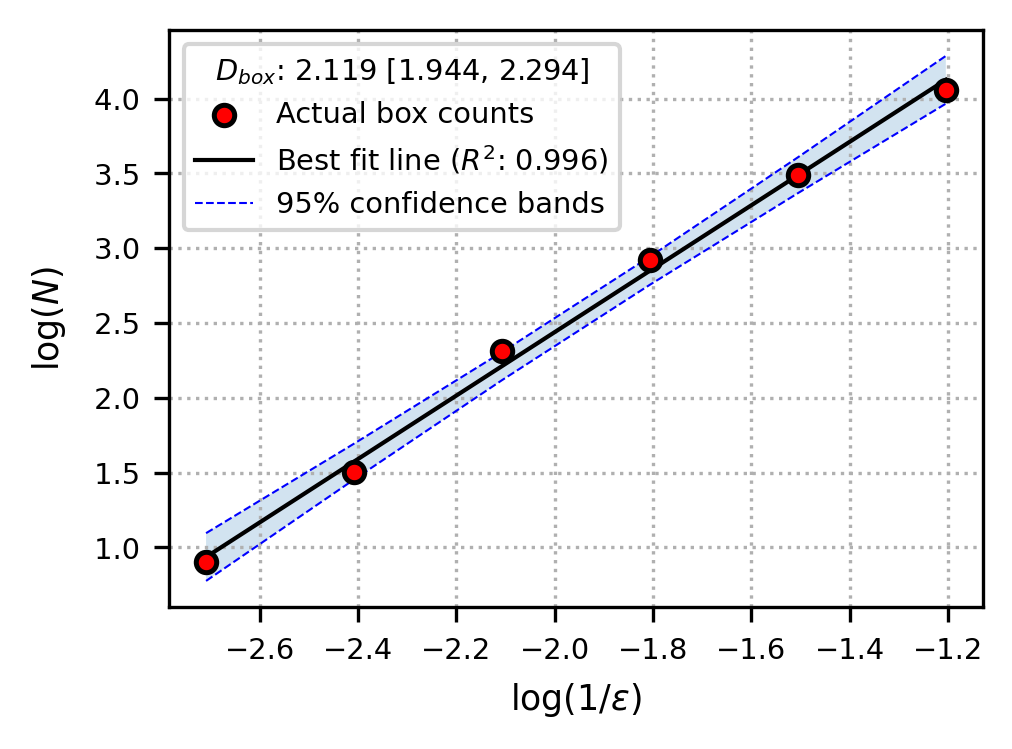

  Representing the surface by treating each atom as exact spheres...
    (1/eps)    (# bulk)    (# surf)
      0.58           0        1592
      0.69           0        2096
      0.79         134        3290
      0.92         494        4802
      1.09         542        6386
      1.27        1622        8978
      1.48        2286       12380
      1.74        8426       18710
      2.02       14200       24512
      2.36       26872       33848


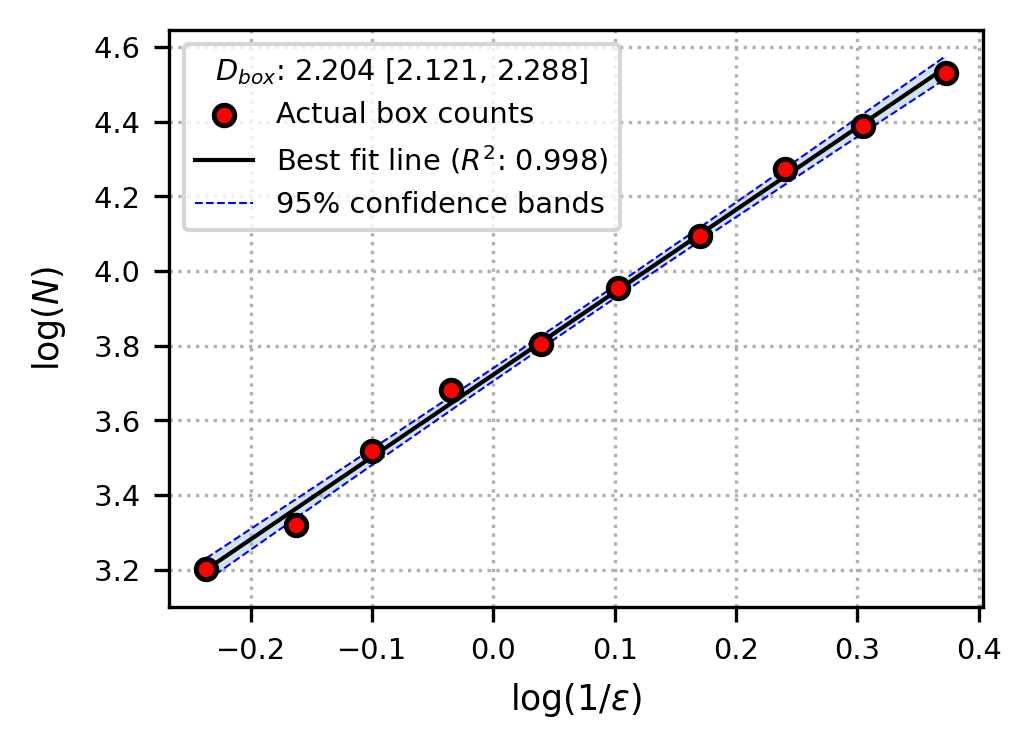

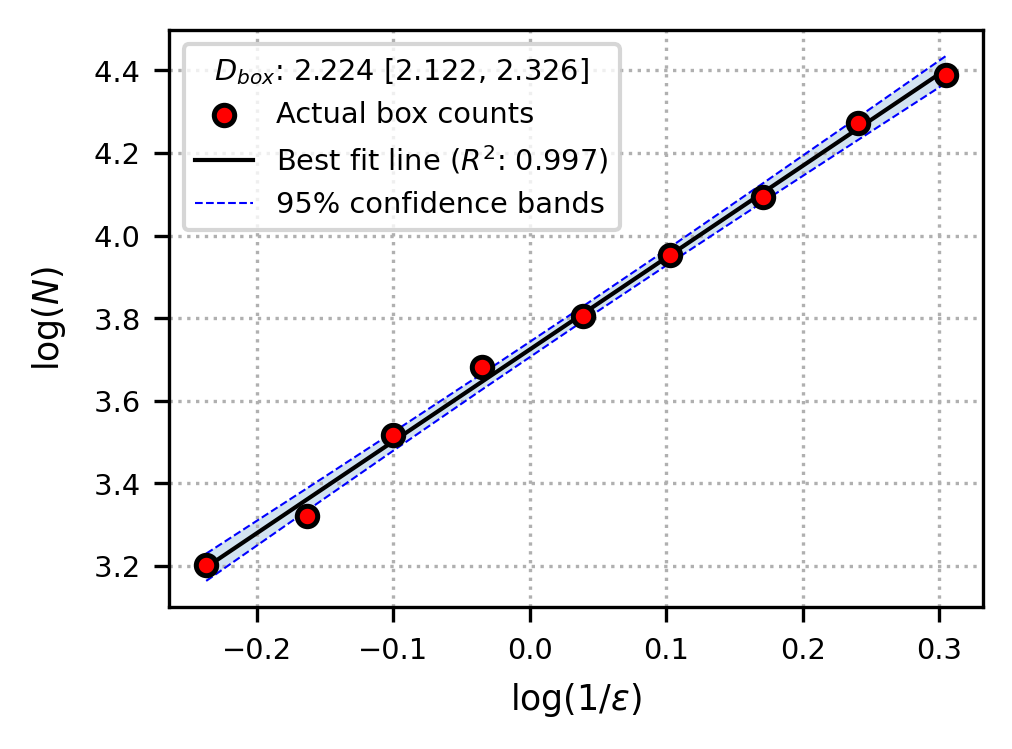

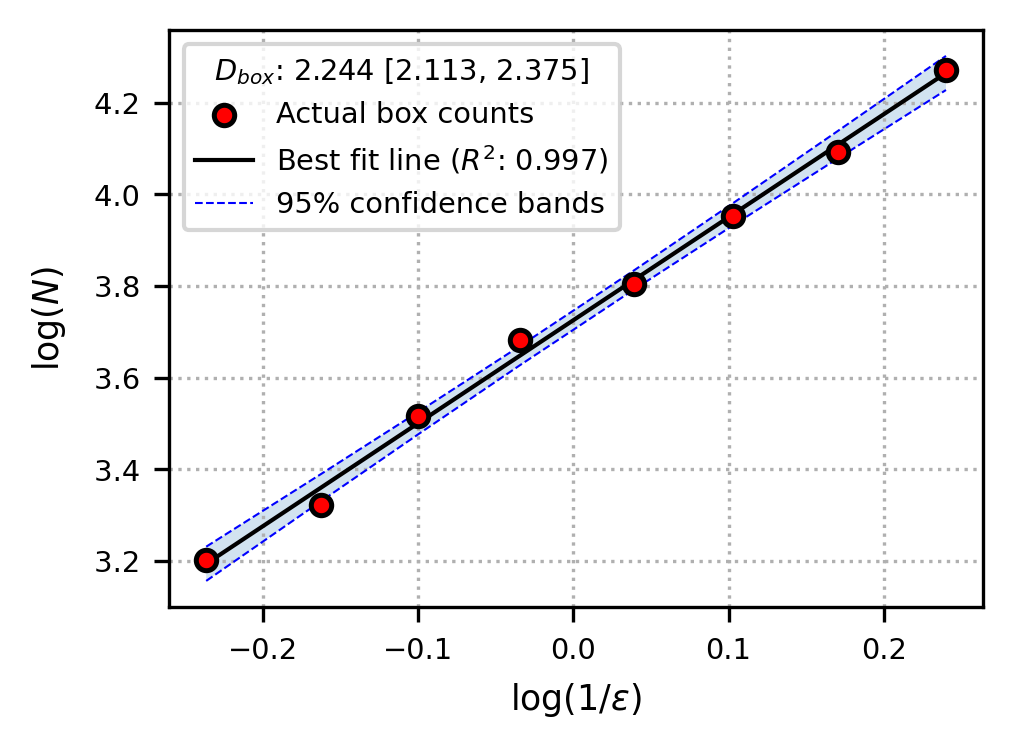

  Point clouds  D_Box: 2.1189 [1.9438, 2.2940],  R2: 0.9965
  Exact surface D_Box: 2.2443 [2.1133, 2.3752],  R2: 0.9966


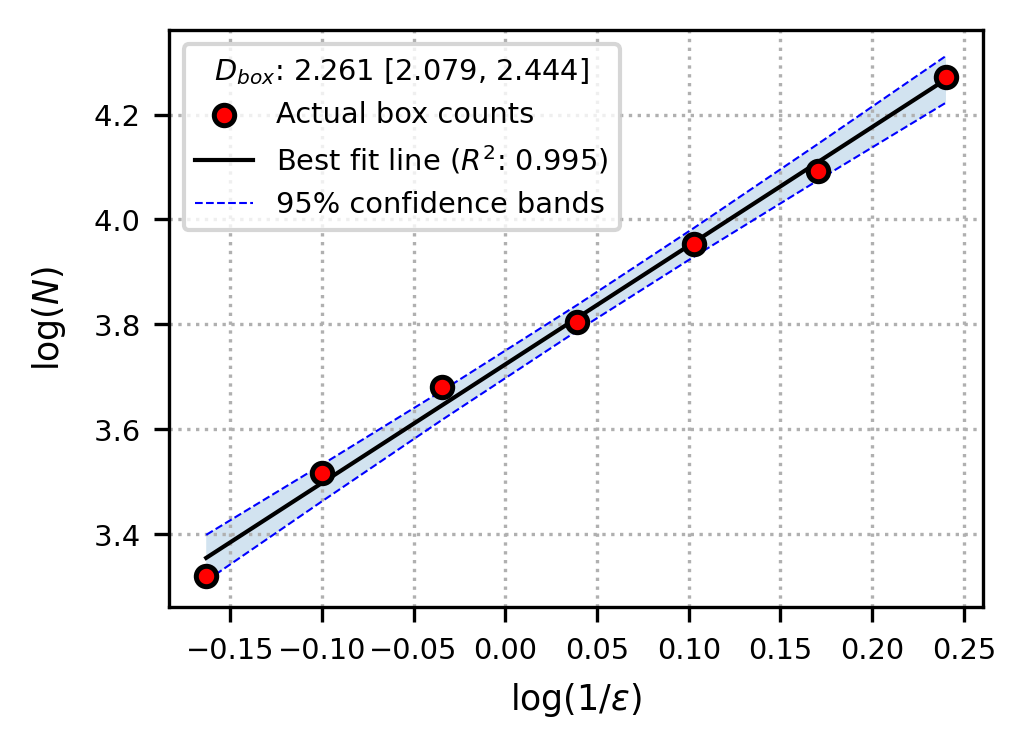

In [3]:
from sphractal import runBoxCnt

fastBCexePath = '../src/fastBC/3DbinImBCcpu.exe'
boxCntResults = runBoxCnt(xyzFilePath, exePath=fastBCexePath, showPlot=True, verbose=True)

## Breaking It All Down

We can have a more detailed look at how the `runBoxCnt()` function was composed.

### Compute Atomic Information

The `xyz` or `lmp` file is first parsed to obtain the atomic information needed for the following steps.

In [4]:
from sphractal import readXYZ, findNN, findSurf

eles, rads, xyzs, maxrange, minxyz, maxxyz = readXYZ(xyzFilePath)
neighs, bondlens = findNN(rads, xyzs, minxyz, maxxyz, rads.max(), 1.2)
surfs = findSurf(xyzs, neighs, 'alphaShape', 2*rads.min())

### Surface Representation as Point Clouds

We could represent the surface of a complex 3D object consisting of spherical entities as point clouds:

<p align="center">
  <img src="figs/exampleSurfPointCloud.png" width="200" height="200"/>
</p>

<p align="center">
  <img src="figs/exampleSurfPointCloudSliced.png" width="150" height="150"/>
</p>

The white and red points correspond to those lying on the outer surface (which are of interest) and inner surface (which are removed in this case, but could be retained if desired); while the blue points are the centers of the surface atoms from which the white and red points were generated around.

We can then turn the surface of interest (either white points alone or including red points depending on use case) into a 3D binary image via voxelisation:

<p align="center">
  <img src="figs/exampleSurfVoxels.png" width="200" height="200"/>
</p>

<p align="center">
  <img src="figs/exampleSurfVoxelsSliced.png" width="150" height="150"/>
</p>

And run the box-counting algorithm to collect the box counts when different box lengths are used:

In [5]:
from sphractal import getVoxelBoxCnts

scalesPointCloud, countsPointCloud = getVoxelBoxCnts(eles, rads, surfs, xyzs, neighs, 
                                                     'example', radType='atomic', exePath=fastBCexePath, verbose=True)

  Approximating the surface with 300 point clouds for each atom...
    33204 surface points -> 33204 voxels, # grids: 1024


Next we can calculate the box-counting dimension from the slope of a linear regression that is fitted to the data collected. The `_PC` suffix was added to `npName` to prevent overwriting of the figures generated if the figures were to be saved (if `saveFig=True`) -- which is not the case here, but this is done automatically by `runBoxCnt()`:

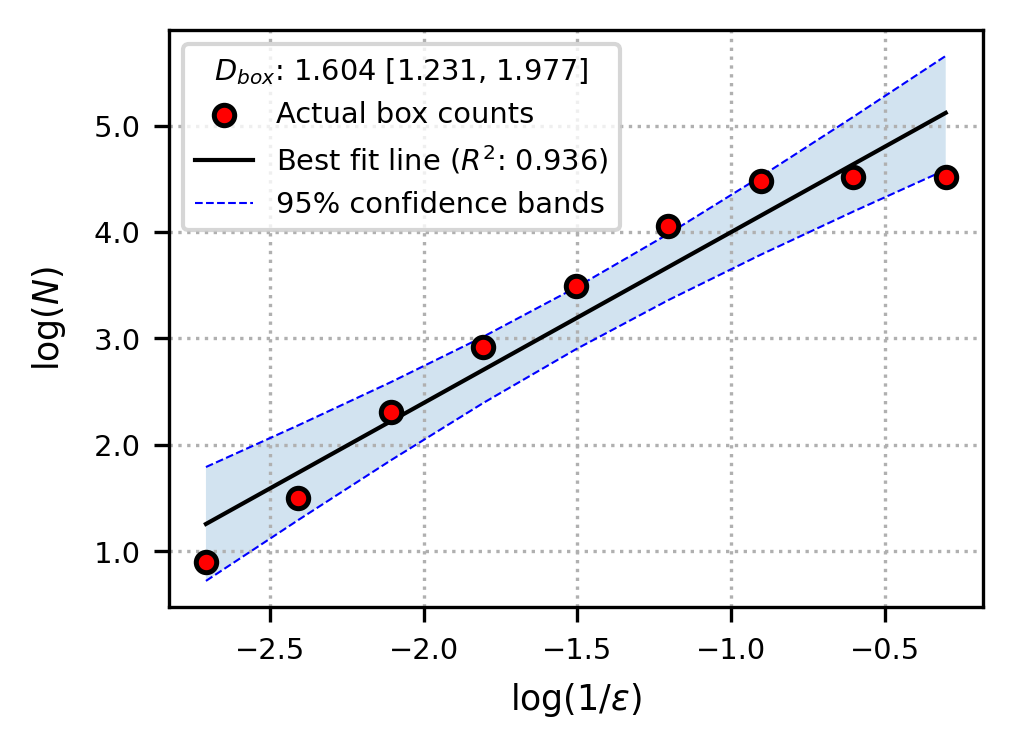

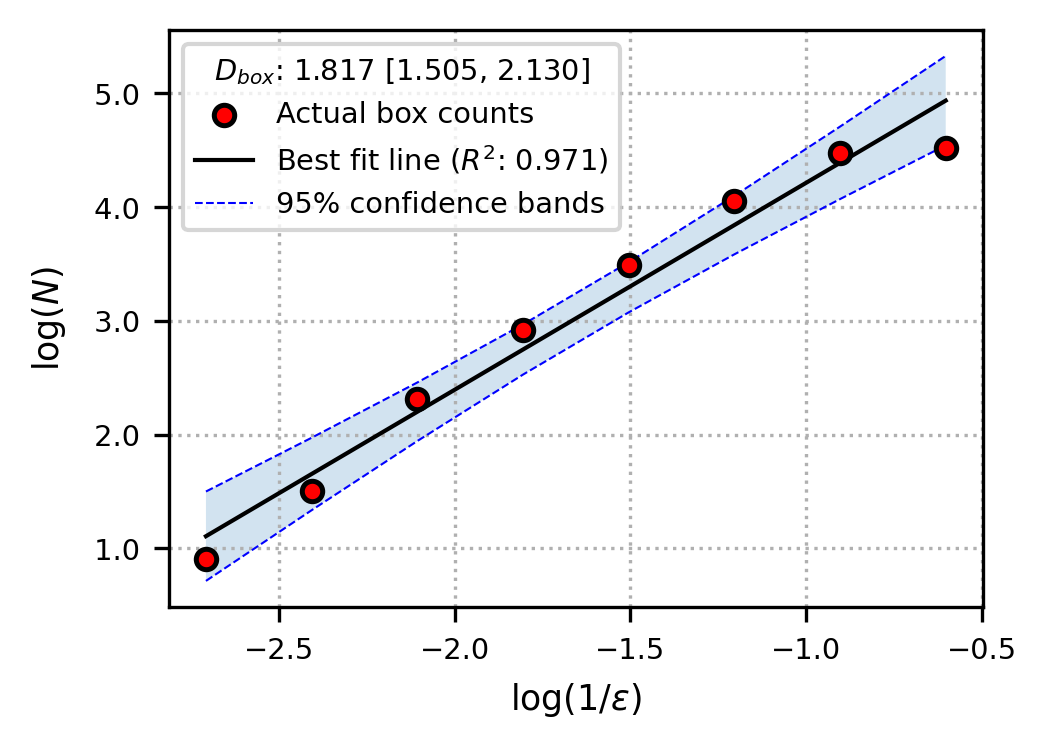

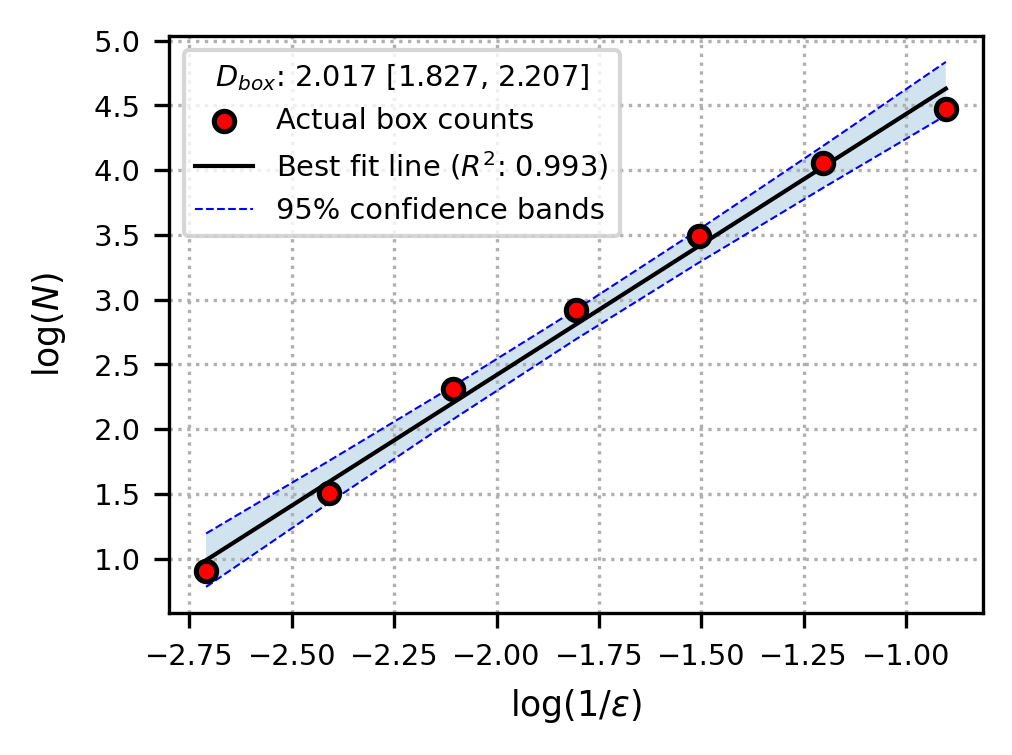

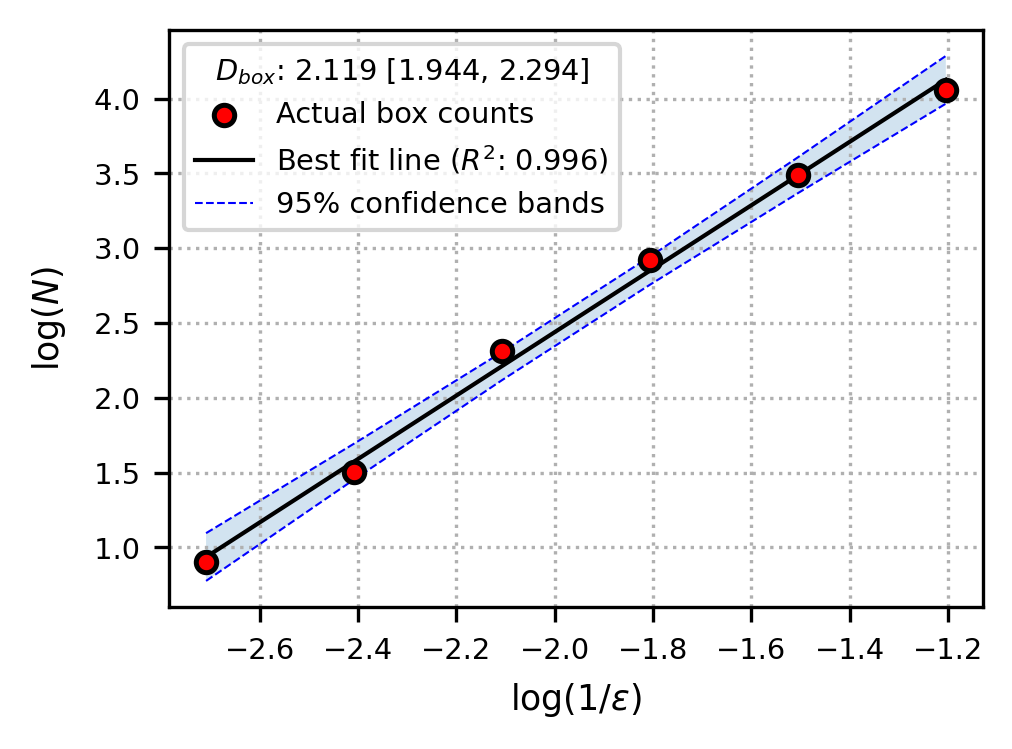

In [6]:
from sphractal import findSlope

r2PointCloud, bcDimPointCloud, confIntPointCloud = findSlope(scalesPointCloud, countsPointCloud, npName='example_PC', showPlot=True)

### Surface Representation as Mathematically Exact Surface

Alternatively, we could run the box-counting algorithm on the mathematically precise surface to collect the box counts when different box lengths are used:

In [7]:
from sphractal import getSphereBoxCnts

scalesExactSurfs, countsExactSurfs = getSphereBoxCnts(eles, rads, surfs, xyzs, neighs, 
                                                      maxrange, (rads.min() * 0.25, rads.min() * 1), minxyz, 'example', verbose=True)

  Representing the surface by treating each atom as exact spheres...
    (1/eps)    (# bulk)    (# surf)
      0.58           0        1592
      0.69           0        2096
      0.79         134        3290
      0.92         494        4802
      1.09         542        6386
      1.27        1622        8978
      1.48        2286       12380
      1.74        8426       18710
      2.02       14200       24512
      2.36       26872       33848


Below are some figures that show the box counts, $N(\epsilon)$, when different box lengths, $\epsilon$ are used. The white boxes are the boxes that cover the outer surface of interest while the red boxes are boxes that were ignored:

$\epsilon = 1.73, N(\epsilon) = 1592$
<p align="center">
  <img src="figs/exampleExactSurfs1.png" width="200" height="200"/>
</p>

$\epsilon = 1.08, N(\epsilon) = 4802$
<p align="center">
  <img src="figs/exampleExactSurfs4.png" width="200" height="200"/>
</p>

$\epsilon = 0.91, N(\epsilon) = 6386$
<p align="center">
  <img src="figs/exampleExactSurfs5.png" width="200" height="200"/>
</p>

$\epsilon = 0.58, N(\epsilon) = 18710$
<p align="center">
  <img src="figs/exampleExactSurfs8.png" width="200" height="200"/>
</p>

$\epsilon = 0.42, N(\epsilon) = 33848$
<p align="center">
  <img src="figs/exampleExactSurfs10.png" width="200" height="200"/>
</p>

We can then calculate the box-counting dimension from the slope of a linear regression that is fitted to the data collected:

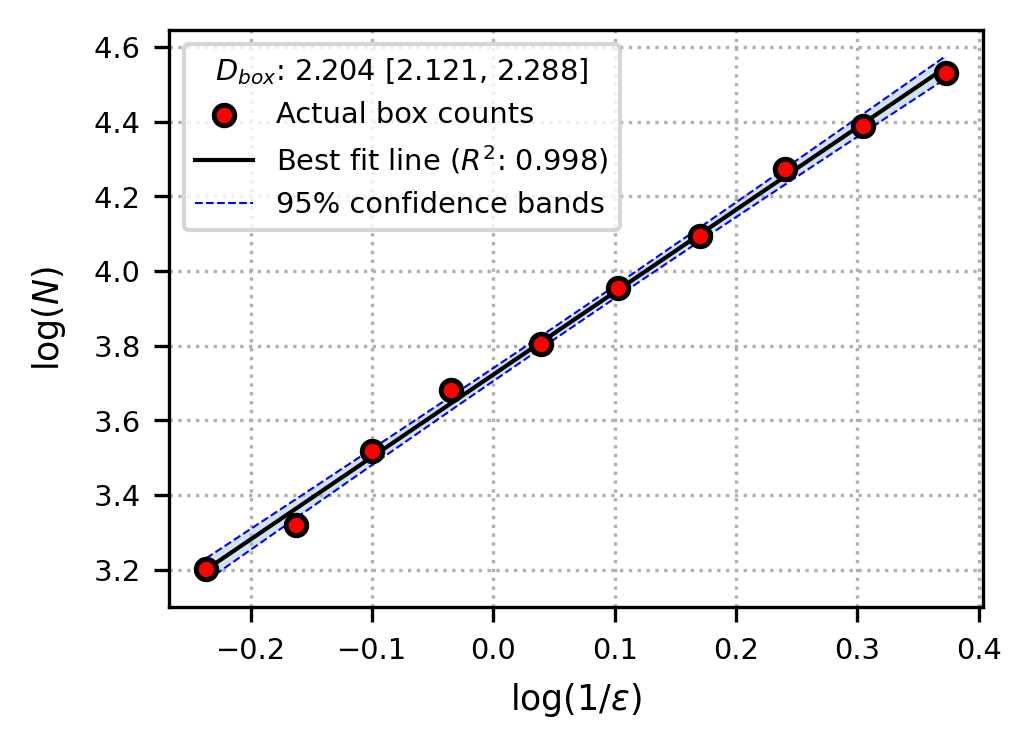

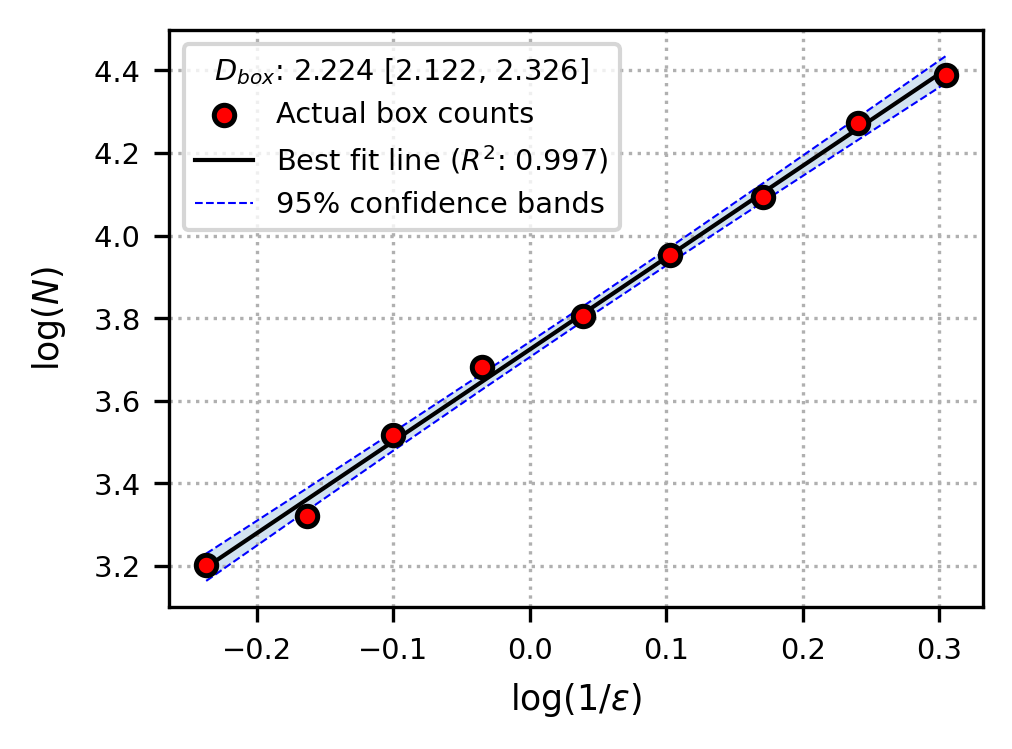

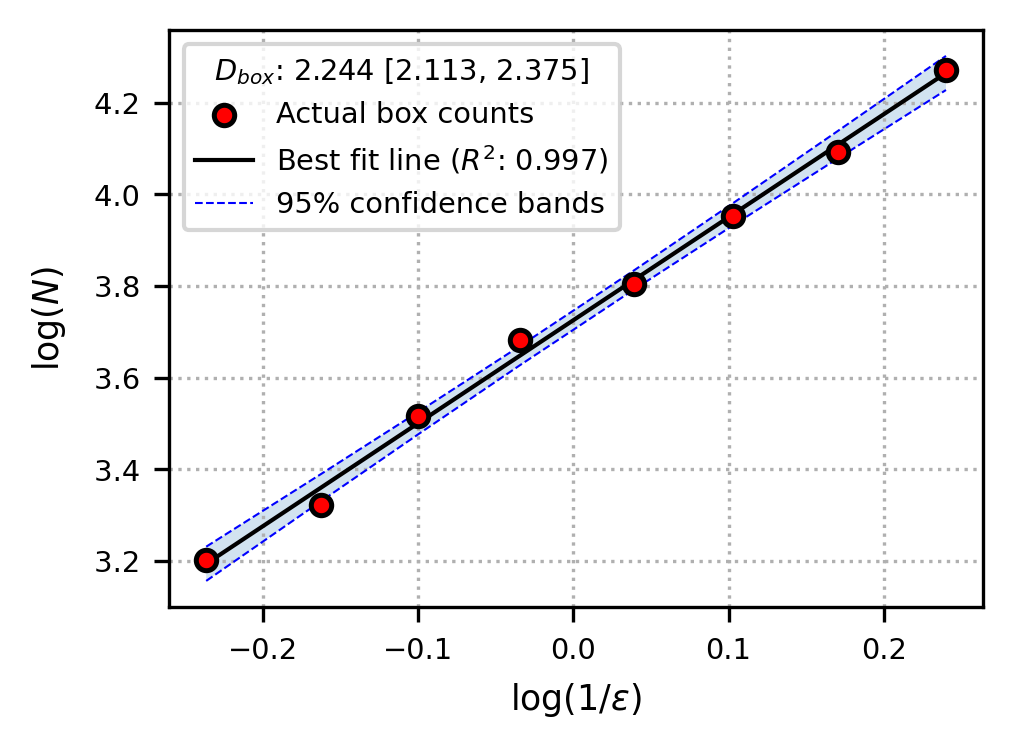

In [8]:
r2ExactSurfs, bcDimExactSurfs, confIntExactSurfs = findSlope(scalesExactSurfs, countsExactSurfs, npName='example_ES', showPlot=True)